In [1]:
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Q러닝 구조
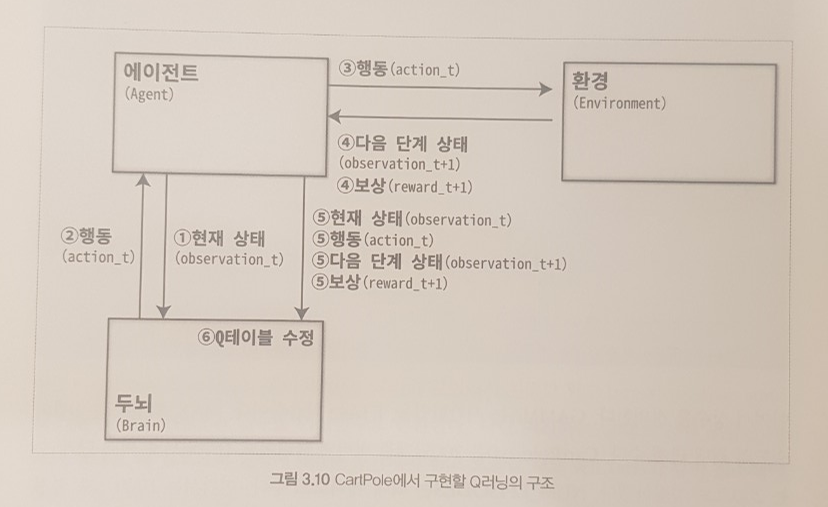

In [5]:
import gym

In [8]:
from JSAnimation.IPython_display import display_animation
import matplotlib.animation as animation

In [25]:
def display_frames_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save('movie_cartpole.mp4')
    display(display_animation(anim,default_mode='loop'))

### 필요한 상수들

In [10]:
ENV = 'CartPole-v0'
NUM_DIZITIZED  = 6
GAMMA = 0.99
lr = 0.5
MAX_STEPS = 200
NUM_EPISODES = 1000

### Agent class

In [13]:
class Agent:
    '''CartPole 에이전트 역할을 할 클래스, 봉 달린 수레이다'''

    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)  # 에이전트가 행동을 결정하는 두뇌 역할

    def update_Q_function(self, observation, action, reward, observation_next):
        '''Q함수 수정'''
        self.brain.update_Q_table(
            observation, action, reward, observation_next)

    def get_action(self, observation, step):
        '''행동 결정'''
        action = self.brain.decide_action(observation, step)
        return action

In [18]:
class Brain:
    '''에이전트의 두뇌 역할을 하는 클래스, Q러닝을 실제 수행'''

    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # 행동의 가짓수(왼쪽, 오른쪽)를 구함

        # Q테이블을 생성. 줄 수는 상태를 구간수^4(4는 변수의 수)가지 값 중 하나로 변환한 값, 열 수는 행동의 가짓수
        self.q_table = np.random.uniform(low=0, high=1, size=(
            NUM_DIZITIZED**num_states, num_actions))


    def bins(self, clip_min, clip_max, num):
        '''관측된 상태(연속값)를 이산변수로 변환하는 구간을 계산'''
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]

    def digitize_state(self, observation):
        '''관측된 상태 observation을 이산변수로 변환'''
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
            np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
            np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
            np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))
        ]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])

    def update_Q_table(self, observation, action, reward, observation_next):
        '''Q러닝으로 Q테이블을 수정'''
        state = self.digitize_state(observation)  # 상태를 이산변수로 변환
        state_next = self.digitize_state(observation_next)  # 다음 상태를 이산변수로 변환
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + \
            lr * (reward + GAMMA * Max_Q_next - self.q_table[state, action])

    def decide_action(self, observation, episode):
        '''ε-greedy 알고리즘을 적용하여 서서히 최적행동의 비중을 늘림'''
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions)  # 0,1 두 가지 행동 중 하나를 무작위로 선택
        return action

In [22]:
class Environment:
    '''CartPole을 실행하는 환경 역할을 하는 클래스'''

    def __init__(self):
        self.env = gym.make(ENV)  # 실행할 태스크를 설정
        num_states = self.env.observation_space.shape[0]  # 태스크의 상태 변수 수를 구함
        num_actions = self.env.action_space.n  # 가능한 행동 수를 구함
        self.agent = Agent(num_states, num_actions)  # 에이전트 객체를 생성

    def run(self):
        '''실행'''
        complete_episodes = 0  # 성공한(195단계 이상 버틴) 에피소드 수
        is_episode_final = False  # 마지막 에피소드 여부
        frames = []  # 애니메이션을 만드는데 사용할 이미지를 저장하는 변수

        for episode in range(NUM_EPISODES):  # 에피소드 수 만큼 반복
            observation = self.env.reset()  # 환경 초기화

            for step in range(MAX_STEPS):  # 1 에피소드에 해당하는 반복

                if is_episode_final is True:  # 마지막 에피소드이면 frames에 각 단계의 이미지를 저장
                    frames.append(self.env.render(mode='rgb_array'))

                # 행동을 선택
                action = self.agent.get_action(observation, episode)

                # 행동 a_t를 실행하여 s_{t+1}, r_{t+1}을 계산
                observation_next, _, done, _ = self.env.step(
                    action)  # reward, info는 사용하지 않으므로 _로 처리함

                # 보상을 부여
                if done:  # 200단계를 넘어서거나 일정 각도 이상 기울면 done의 값이 True가 됨
                    if step < 195:
                        reward = -1  # 봉이 쓰러지면 페널티로 보상 -1 부여
                        complete_episodes = 0  # 195단계 이상 버티면 해당 에피소드를 성공 처리
                    else:
                        reward = 1  # 쓰러지지 않고 에피소드를 끝내면 보상 1 부여
                        complete_episodes += 1  # 에피소드 연속 성공 기록을 업데이트
                else:
                    reward = 0  # 에피소드 중에는 보상이 0

                # 다음 단계의 상태 observation_next로 Q함수를 수정
                self.agent.update_Q_function(
                    observation, action, reward, observation_next)

                # 다음 단계 상태 관측
                observation = observation_next

                # 에피소드 마무리
                if done:
                    print('{0} Episode: Finished after {1} time steps'.format(
                        episode, step + 1))
                    break

            if is_episode_final is True:  # 마지막 에피소드에서는 애니메이션을 만들고 저장
                display_frames_gif(frames)
                break

            if complete_episodes >= 10:  # 10 에피소드 연속으로 성공한 경우
                print('10 에피소드 연속 성공')
                is_episode_final = True  # 다음 에피소드가 마지막 에피소드가 됨

In [23]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

0 Episode: Finished after 47 time steps
1 Episode: Finished after 10 time steps
2 Episode: Finished after 15 time steps
3 Episode: Finished after 10 time steps
4 Episode: Finished after 41 time steps
5 Episode: Finished after 19 time steps
6 Episode: Finished after 18 time steps
7 Episode: Finished after 18 time steps
8 Episode: Finished after 11 time steps
9 Episode: Finished after 11 time steps
10 Episode: Finished after 12 time steps
11 Episode: Finished after 96 time steps
12 Episode: Finished after 17 time steps
13 Episode: Finished after 10 time steps
14 Episode: Finished after 51 time steps
15 Episode: Finished after 11 time steps
16 Episode: Finished after 33 time steps
17 Episode: Finished after 30 time steps
18 Episode: Finished after 25 time steps
19 Episode: Finished after 15 time steps
20 Episode: Finished after 31 time steps
21 Episode: Finished after 18 time steps
22 Episode: Finished after 131 time steps
23 Episode: Finished after 106 time steps
24 Episode: Finished aft

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


168 Episode: Finished after 200 time steps


ValueError: unknown file extension: .mp4

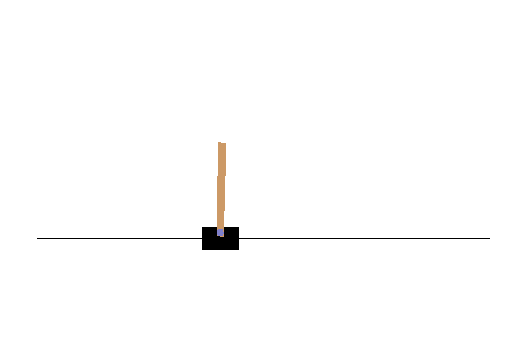

In [26]:
# main
cartpole_env = Environment()
cartpole_env.run()

In [30]:
!pip install ffmpeg-python

OSError: [Errno 12] Cannot allocate memory